<a href="https://colab.research.google.com/github/worklifesg/Computer-Vision-Algorithms-and-Projects/blob/main/4-Detecting%20Parkinson%20Disease/parkinson_spiral_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align='center'> Detecting Parkinson’s Disease with OpenCV, Computer Vision, and the Spiral/Wave Test </h2>

The dataset consists of:
  - Spiral - 102 images (72 training and 30 testing)
  - Wave - 102 images (72 training and 30 testing)
  

#### 1. Import Libraries

In [1]:
import numpy as np
import cv2
import os

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_auc_score
from skimage import feature
from imutils import build_montages, paths

from sklearn.metrics import accuracy_score
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

#### 2. Function to load iamges and read them (quantify them) and split into images and labels

In [2]:
def load_split(path):
	# grab the list of images in the input directory, then initialize
	# the list of data (i.e., images) and class labels
	imagePaths = list(paths.list_images(path))
	data = []
	labels = []
	# loop over the image paths
	for imagePath in imagePaths:
		# extract the class label from the filename
		label = imagePath.split(os.path.sep)[-2]
		# load the input image, convert it to grayscale, and resize
		# it to 200x200 pixels, ignoring aspect ratio
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		image = cv2.resize(image, (200, 200))
		# threshold the image such that the drawing appears as white
		# on a black background
		image = cv2.threshold(image, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		# quantify the image
		features = quantify_image(image)
		# update the data and labels lists, respectively
		data.append(features)
		labels.append(label)
	# return the data and labels
	return (np.array(data), np.array(labels))

def quantify_image(image):
	# compute the histogram of oriented gradients feature vector for
	# the input image
	features = feature.hog(image, orientations=9,
		pixels_per_cell=(10, 10), cells_per_block=(2, 2),
		transform_sqrt=True, block_norm="L1")
	# return the feature vector
	return features

#### 3. Spiral Dataset

In [3]:
trainingPath = '/content/drive/MyDrive/parkinson/dataset/spiral/training'
testingPath = '/content/drive/MyDrive/parkinson/dataset/spiral/testing'

(trainX, trainY) = load_split(trainingPath)
(testX, testY) = load_split(testingPath)

In [4]:
le = LabelEncoder()
trainY = le.fit_transform(trainY)
testY = le.fit_transform(testY)

#### 4. Functions to plot confusion matrix and predictions


In [5]:
def cm_draw(testY,y_pred):
    cm = pd.crosstab(testY, y_pred, rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(cm, 
            xticklabels=['Healthy', 'Parkinson'],
            yticklabels=['Healthy', 'Parkinson'],
            annot=True,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()
def prediction(y_pred,testY):
  print('The accuracy is: ',accuracy_score(testY, y_pred)*100, ' %')
  print('ROC AUC score is: ',roc_auc_score(testY,y_pred)*100, ' %')


def pred_plot(testingPat,model):
  #Plotting testing images and their prediction

  testingPaths = list(paths.list_images(testingPath))
  idxs = np.arange(0,len(testingPaths))
  idxs = np.random.choice(idxs,size=(30,),replace=False)

  images=[]

  #loop over testing samples
  for i in idxs:
    image = cv2.imread(testingPaths[i]) #read the image
    output = image.copy() #clone it
    output = cv2.resize(output,(128,128))

    #preprocess the image

    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image,(200,200))
    image = cv2.threshold(image,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    #quanity the image and predict the test model

    features = quantify_image(image)
    preds = model.predict([features])
    label = le.inverse_transform(preds)[0]

    #output

    color = (0,255,0) if label =="healthy" else (0,0,255)
    cv2.putText(output,label,(3,20),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
    images.append(output)

  montage = build_montages(images,(128,128),(5,5))[0]

  cv2_imshow(montage)
  cv2.waitKey(0)


#### 5 (a) RandomForestClassifier

The accuracy is:  86.66666666666667  %
ROC AUC score is:  86.66666666666667  %


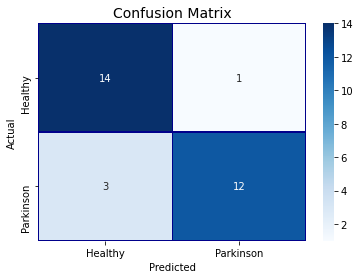

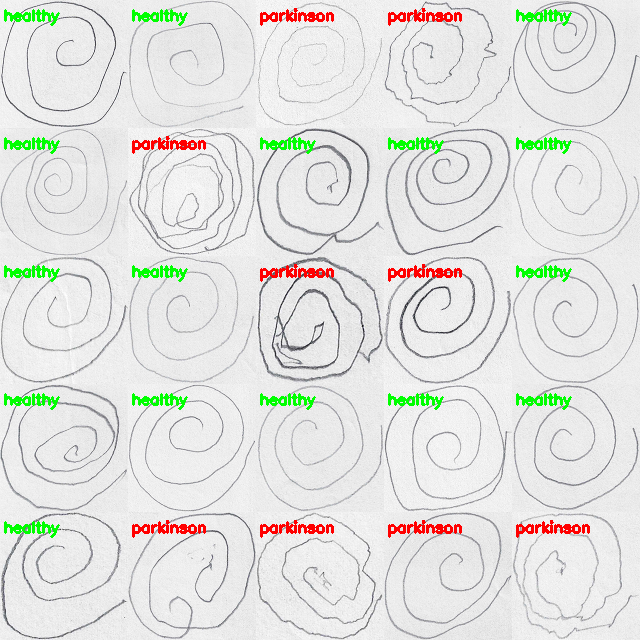

In [6]:
clf1 = RandomForestClassifier(n_jobs=4, 
                             random_state=21,
                             criterion='gini',
                             n_estimators=100,
                             verbose=False)
clf1.fit(trainX,trainY)
y_pred1=clf1.predict(testX)

prediction(y_pred1,testY)
cm_draw(testY,y_pred1)
pred_plot(testingPath,clf1)

#### 5 (b) AdaBoostClassifier

The accuracy is:  70.0  %
ROC AUC score is:  70.0  %


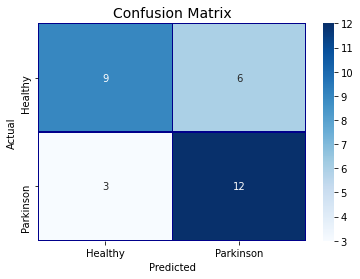

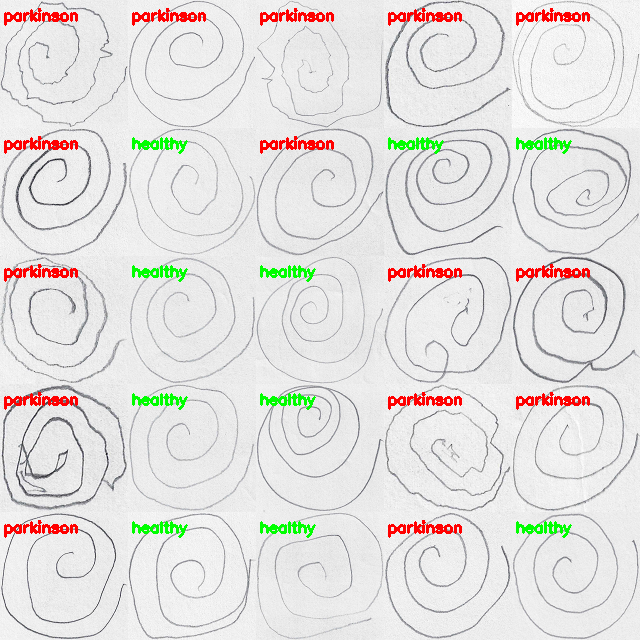

In [7]:
clf2 = AdaBoostClassifier(random_state=21,
                             algorithm='SAMME.R',
                             learning_rate=0.8,
                             n_estimators=100,)

clf2.fit(trainX,trainY)
y_pred2=clf2.predict(testX)

prediction(y_pred2,testY)
cm_draw(testY,y_pred2)
pred_plot(testingPath,clf2)

#### 5(c) XGBoost XGBRegressor

The accuracy is:  83.33333333333334  %
ROC AUC score is:  83.33333333333334  %


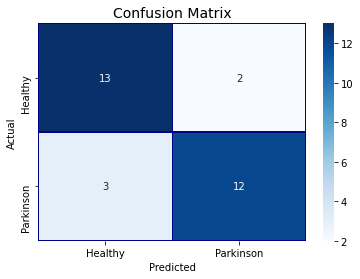

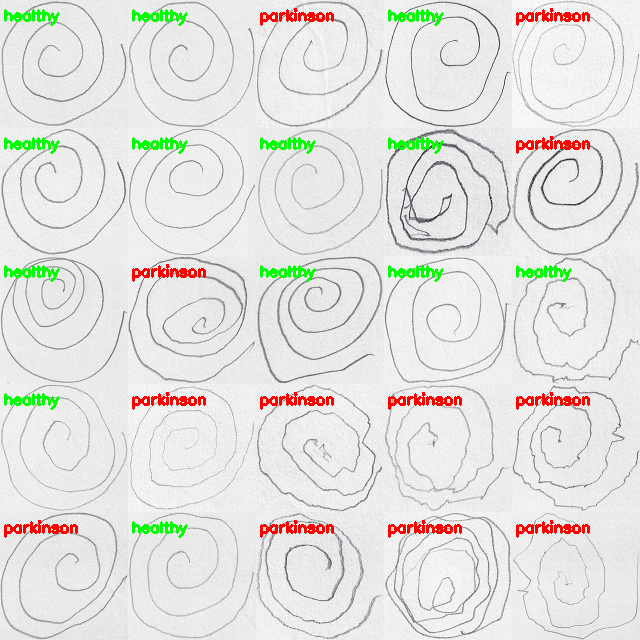

In [8]:
clf3 = xgb.XGBClassifier(eta=0.039,max_depth=2,objective='binary:logistic',silent= True,
      subsample=0.8,colsample_bytree=0.9,eval_metric='auc',random_state=21,n_estimators=20)

clf3.fit(trainX,trainY)
y_pred3=clf3.predict(testX)

prediction(y_pred3,testY)
cm_draw(testY,y_pred3)
pred_plot(testingPath,clf3)

#### 5(d) XGBoost using Dmatrix to run algorithm more efficiently

In [9]:
D_train = xgb.DMatrix(trainX,trainY)
D_test = xgb.DMatrix(testX,testY)

param={'eta':0.039,'max_depth':2,'objective':'binary:logistic','silent': True,
      'subsample':0.8,'colsample_bytree':0.9,'eval_metric':'auc','random_state':21}

watchlist = [(D_train, 'train'), (D_test, 'test')]
clf4 = xgb.train(param, D_train,30,watchlist,maximize=True)

y_pred4=clf4.predict(D_test)
print('ROC AUC score is: ',roc_auc_score(testY,y_pred4)*100, ' %')

[0]	train-auc:0.865355	test-auc:0.684444
[1]	train-auc:0.956404	test-auc:0.791111
[2]	train-auc:0.979552	test-auc:0.886667
[3]	train-auc:0.984182	test-auc:0.882222
[4]	train-auc:0.993056	test-auc:0.888889
[5]	train-auc:0.99537	test-auc:0.873333
[6]	train-auc:0.993056	test-auc:0.891111
[7]	train-auc:0.996142	test-auc:0.893333
[8]	train-auc:0.997685	test-auc:0.911111
[9]	train-auc:0.996142	test-auc:0.911111
[10]	train-auc:0.999228	test-auc:0.937778
[11]	train-auc:0.998457	test-auc:0.937778
[12]	train-auc:1	test-auc:0.937778
[13]	train-auc:1	test-auc:0.937778
[14]	train-auc:1	test-auc:0.937778
[15]	train-auc:1	test-auc:0.942222
[16]	train-auc:1	test-auc:0.937778
[17]	train-auc:1	test-auc:0.933333
[18]	train-auc:1	test-auc:0.924444
[19]	train-auc:1	test-auc:0.92
[20]	train-auc:1	test-auc:0.924444
[21]	train-auc:1	test-auc:0.924444
[22]	train-auc:1	test-auc:0.928889
[23]	train-auc:1	test-auc:0.942222
[24]	train-auc:1	test-auc:0.933333
[25]	train-auc:1	test-auc:0.942222
[26]	train-auc:0.9992